In [52]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [53]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [54]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [55]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [56]:
# reflect an existing database into a new model
base = automap_base()
base.prepare(autoload_with=engine)
# reflect the tables
base.classes

In [57]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [58]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [59]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [79]:
# Find the most recent date in the data set
most_recent_date = session.query(func.max(measurement.date)).scalar()

print(most_recent_date)

2017-08-23


In [80]:
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d') # Used Xpert Learning Assistant to convert from string to datetime
type(most_recent_date)

datetime.datetime

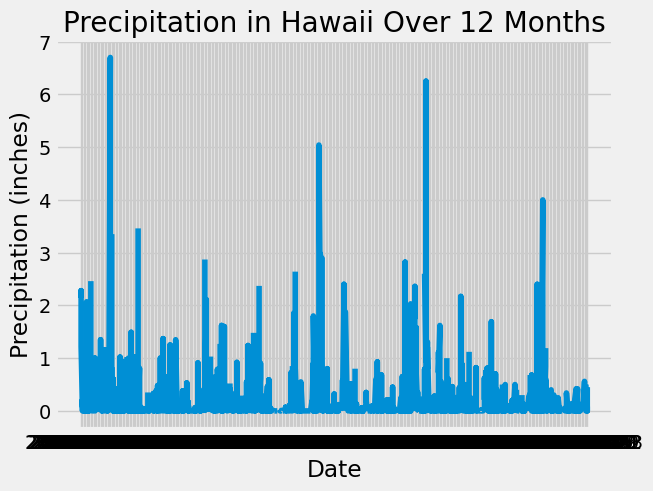

In [81]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)
# one_year_ago = most_recent_date - 365

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_prcp_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Sort the dataframe by date
one_year_prcp_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(one_year_prcp_df['date'], one_year_prcp_df['prcp'])
plt.title('Precipitation in Hawaii Over 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.show()

In [83]:
# Use Pandas to calculate the summary statistics for the precipitation data
one_year_prcp_df_summary_stats = one_year_prcp_df.describe()
one_year_prcp_df_summary_stats

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [86]:
# Design a query to calculate the total number of stations in the dataset
total_n_stations = session.query(func.count(station.id)).scalar()
total_n_stations

9

In [91]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sorted_active_stations = (
    session.query(measurement.station, func.count(measurement.id).label('station'))
    .group_by(measurement.station)
    .order_by(func.count(measurement.id).desc())
    .all()
)
sorted_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = (
    session.query(measurement.station)
    .group_by(measurement.station)
    .order_by(func.count(measurement.id).desc())
    .first()
)
most_active_station # US00519281

# Check if we found a most active station
if most_active_station:
    station_id = most_active_station[0]

    # Step 2: Query minimum, maximum, and average temperatures for the most active station
    temperature_stats = (
        session.query(
            func.min(measurement.tobs).label('min_temp'),
            func.max(measurement.tobs).label('max_temp'),
            func.avg(measurement.tobs).label('avg_temp')
        )
        .filter(measurement.station == station_id)
        .one()  # Use .one() if you expect exactly one result
    )

    # Print the results
    print(f"Most Active Station ID: {station_id}")
    print(f"Minimum Temperature: {temperature_stats.min_temp}")
    print(f"Maximum Temperature: {temperature_stats.max_temp}")
    print(f"Average Temperature: {temperature_stats.avg_temp}")
else:
    print("No active stations found.")

Most Active Station ID: USC00519281
Minimum Temperature: 54.0
Maximum Temperature: 85.0
Average Temperature: 71.66378066378067


Most Active Station ID: USC00519281
Temperature Observed for the Last 12 Months:
Date: 2016-08-24, Temperature: 77.0
Date: 2016-08-25, Temperature: 80.0
Date: 2016-08-26, Temperature: 80.0
Date: 2016-08-27, Temperature: 75.0
Date: 2016-08-28, Temperature: 73.0
Date: 2016-08-29, Temperature: 78.0
Date: 2016-08-30, Temperature: 77.0
Date: 2016-08-31, Temperature: 78.0
Date: 2016-09-01, Temperature: 80.0
Date: 2016-09-02, Temperature: 80.0
Date: 2016-09-03, Temperature: 78.0
Date: 2016-09-04, Temperature: 78.0
Date: 2016-09-05, Temperature: 78.0
Date: 2016-09-06, Temperature: 73.0
Date: 2016-09-07, Temperature: 74.0
Date: 2016-09-08, Temperature: 80.0
Date: 2016-09-09, Temperature: 79.0
Date: 2016-09-10, Temperature: 77.0
Date: 2016-09-11, Temperature: 80.0
Date: 2016-09-12, Temperature: 76.0
Date: 2016-09-13, Temperature: 79.0
Date: 2016-09-14, Temperature: 75.0
Date: 2016-09-15, Temperature: 79.0
Date: 2016-09-16, Temperature: 78.0
Date: 2016-09-17, Temperature: 79.0
Date: 2016-09-18, T

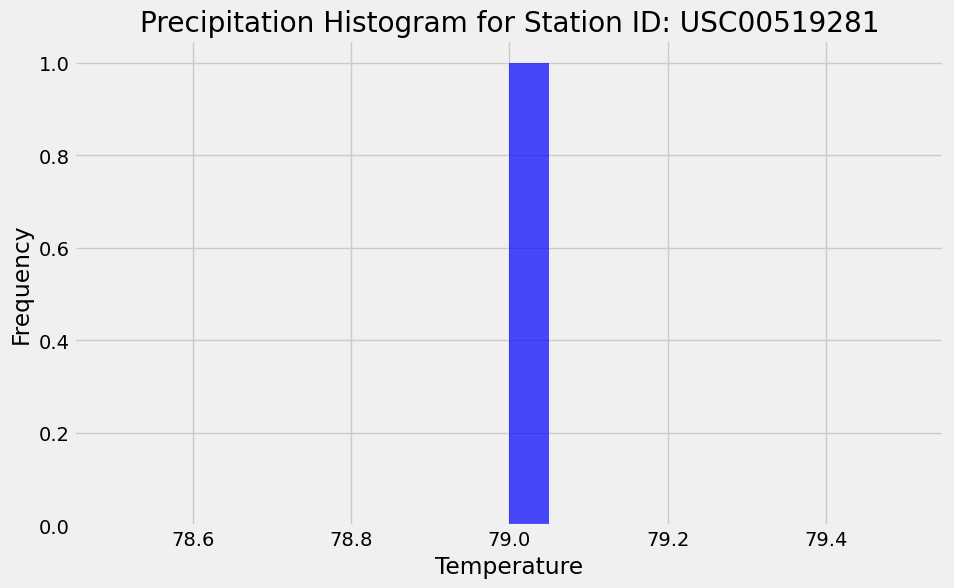

In [102]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
if most_active_station:
    station_id = most_active_station[0]
    # Query for the last 12 months of temperature data for the most active station
    precipitation_data = (
        session.query(measurement.date, measurement.tobs)
        .filter(measurement.date >= one_year_ago, measurement.station == station_id)
        .all()
    )
    # Print the results
    print(f"Most Active Station ID: {station_id}")
    print("Temperature Observed for the Last 12 Months:")
    for date, tobs in precipitation_data:
        print(f"Date: {date}, Temperature: {tobs}")
    # Generate a histogram of the temperature data
    plt.figure(figsize=(10, 6))
    plt.hist(tobs, bins=20, color='blue', alpha=0.7)
    plt.title(f'Precipitation Histogram for Station ID: {station_id}')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No active stations found.")

# Close Session

In [103]:
# Close Session
session.close()